# Import dependencies

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams

from sklearn.preprocessing import PowerTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense

# Prepare the data

In [2]:
path = "../collected_data/"
dir_list = os.listdir(path)

data = pd.DataFrame(columns=pd.read_csv(path + "/" + dir_list[0]).columns[1:])

for file_name in dir_list:
    file_path = path + "/" + file_name
    data_tmp = pd.read_csv(file_path)
    data = pd.concat([data, data_tmp]).reset_index(drop=True)

['tree_reduction_t_0.csv', 'tree_reduction_t_1.csv', 'tree_reduction_t_10.csv', 'tree_reduction_t_100.csv', 'tree_reduction_t_101.csv', 'tree_reduction_t_102.csv', 'tree_reduction_t_103.csv', 'tree_reduction_t_104.csv', 'tree_reduction_t_105.csv', 'tree_reduction_t_106.csv', 'tree_reduction_t_107.csv', 'tree_reduction_t_108.csv', 'tree_reduction_t_109.csv', 'tree_reduction_t_11.csv', 'tree_reduction_t_110.csv', 'tree_reduction_t_111.csv', 'tree_reduction_t_112.csv', 'tree_reduction_t_113.csv', 'tree_reduction_t_114.csv', 'tree_reduction_t_115.csv', 'tree_reduction_t_116.csv', 'tree_reduction_t_117.csv', 'tree_reduction_t_118.csv', 'tree_reduction_t_119.csv', 'tree_reduction_t_12.csv', 'tree_reduction_t_120.csv', 'tree_reduction_t_121.csv', 'tree_reduction_t_122.csv', 'tree_reduction_t_123.csv', 'tree_reduction_t_124.csv', 'tree_reduction_t_125.csv', 'tree_reduction_t_126.csv', 'tree_reduction_t_127.csv', 'tree_reduction_t_128.csv', 'tree_reduction_t_129.csv', 'tree_reduction_t_13.csv',

In [12]:
for col_name in ["vertices_pre", "redexes_pre", "height_pre", "width_pre", "redex_depth" , "step_time"]:
    data[col_name] = pd.to_numeric(data[col_name])

array([[<AxesSubplot: title={'center': 'vertices_pre'}>,
        <AxesSubplot: title={'center': 'redexes_pre'}>],
       [<AxesSubplot: title={'center': 'height_pre'}>,
        <AxesSubplot: title={'center': 'width_pre'}>],
       [<AxesSubplot: title={'center': 'redex_depth'}>,
        <AxesSubplot: title={'center': 'step_time'}>]], dtype=object)

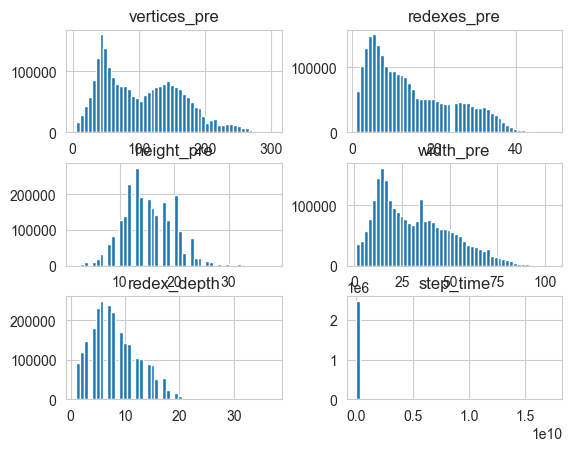

In [13]:
data[["vertices_pre", "redexes_pre", "height_pre", "width_pre", "redex_depth" , "step_time"]].hist(bins=50)

array([[<AxesSubplot: title={'center': 'vertices_pre'}>,
        <AxesSubplot: title={'center': 'redexes_pre'}>],
       [<AxesSubplot: title={'center': 'height_pre'}>,
        <AxesSubplot: title={'center': 'width_pre'}>],
       [<AxesSubplot: title={'center': 'redex_depth'}>,
        <AxesSubplot: title={'center': 'step_time'}>]], dtype=object)

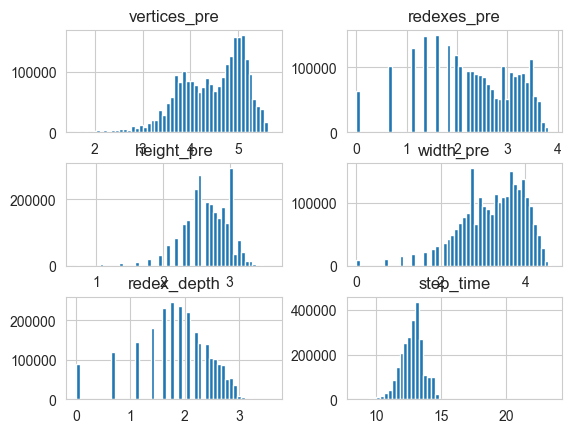

In [14]:
power_trans = PowerTransformer(method='yeo-johnson')

data_norm = pd.DataFrame()
for col_name in ["vertices_pre", "redexes_pre", "height_pre", "width_pre", "redex_depth" , "step_time"]:
    norm_col_data = np.log(data[col_name])
    data_norm[col_name] = norm_col_data

data_norm.hist(bins=50)

In [15]:
data_for_training = data_norm

In [17]:
def split_dataset(dataset, test_ratio=0.1):
    test_indices_filter = np.random.rand(len(dataset)) < test_ratio
    return dataset[~test_indices_filter], dataset[test_indices_filter]


train_ds, test_ds = split_dataset(data_for_training)
print(f"Examples for training {len(train_ds)}")
print(f"Examples for testing {len(test_ds)}")

Examples for training 2227837
Examples for testing 247210


In [19]:
x_train, y_train = train_ds.drop("step_time", axis=1), train_ds[["step_time"]]
x_test, y_test = test_ds.drop("step_time", axis=1), test_ds[["step_time"]]
x_data, y_data = data_for_training.drop("step_time", axis=1), data_for_training[["step_time"]]

# Train the Linear Regression

In [20]:
rcParams['figure.figsize'] = 10, 9


def draw_pred_lines(y_pred, y_real):
    drawing_df = pd.DataFrame({"Pred": y_pred, "Real": y_real})
    drawing_df = drawing_df.sort_values("Real").reset_index(drop=True)

    for key_, val_ in drawing_df.items():
        plt.plot(range(len(val_)), val_, label=key_)

    plt.xlabel("No")
    plt.ylabel("Step Time")
    plt.title("Pred vs Real Step Time")
    plt.legend()
    plt.show()

TRAIN Root Mean Squared Error(RMSE): 0.29155129644170036
TEST Root Mean Squared Error(RMSE): 0.2898850412752018


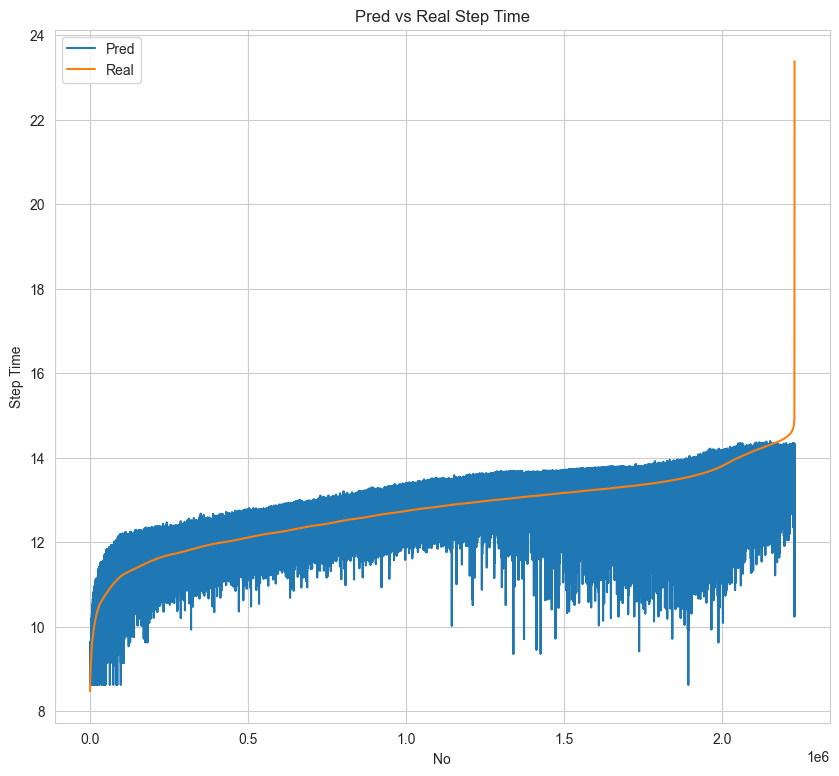

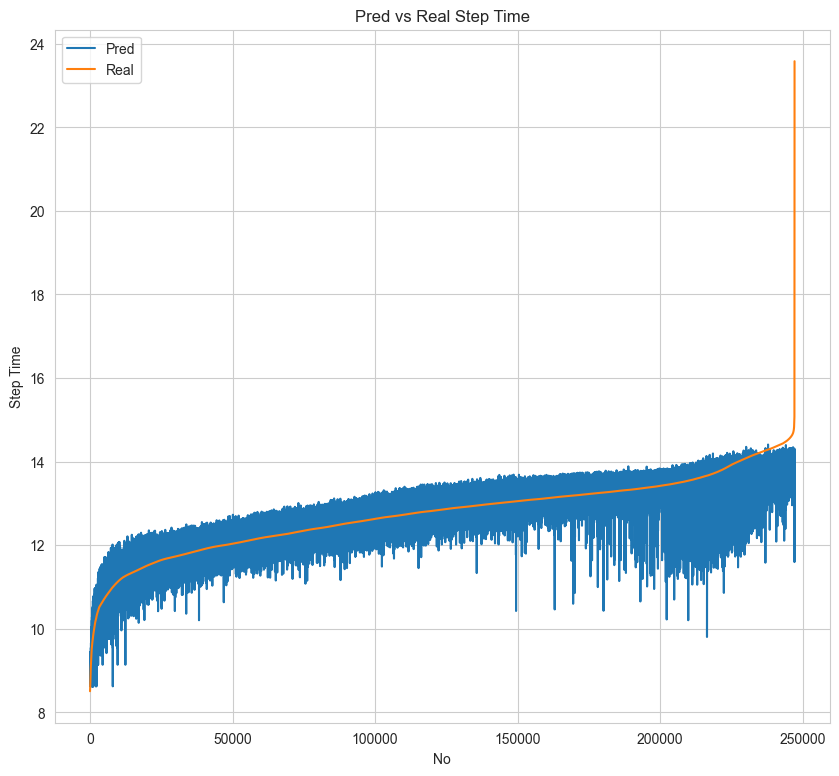

In [22]:
lin_regressor = LinearRegression()
lin_regressor.fit(x_train, y_train)

y_train_pred = lin_regressor.predict(x_train)
y_test_pred = lin_regressor.predict(x_test)

rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)

print("TRAIN Root Mean Squared Error(RMSE):", rmse_train)
print("TEST Root Mean Squared Error(RMSE):", rmse_test)
draw_pred_lines(list(y_train_pred[:, -1]), y_train["step_time"].to_list())
draw_pred_lines(list(y_test_pred[:, -1]), y_test["step_time"].to_list())

ALL RMSE: 0.2913852840926107


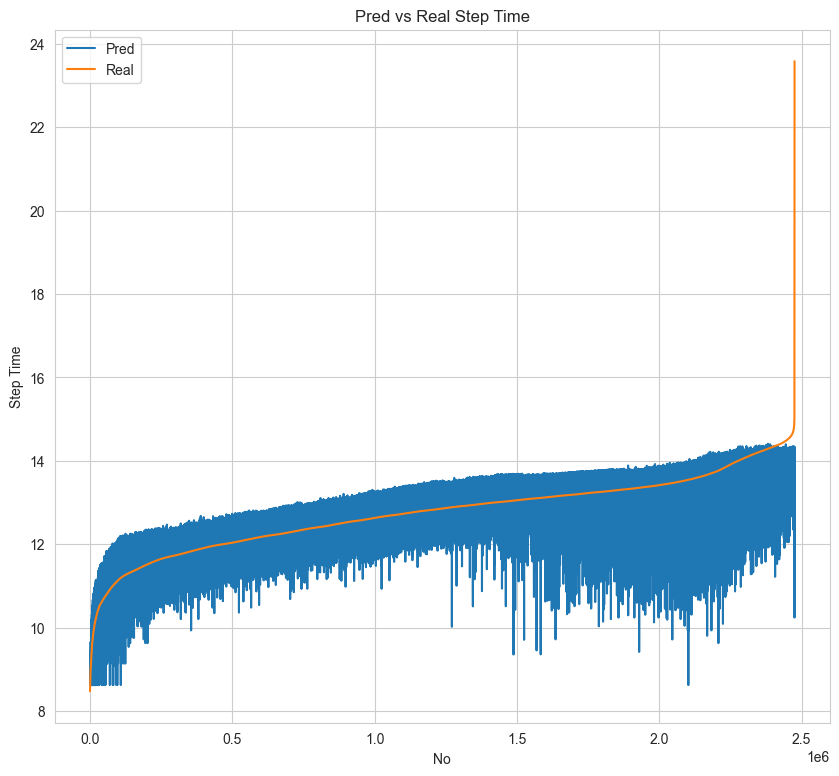

In [24]:
lin_regressor = LinearRegression()
lin_regressor.fit(x_data, y_data)

y_data_pred = lin_regressor.predict(x_data)
rmse_all = mean_squared_error(y_data, y_data_pred, squared=False)
print("ALL RMSE:", rmse_all)
draw_pred_lines(list(y_data_pred[:, -1]), y_data["step_time"].to_list())

# Train the ANN Regression

In [26]:
model = Sequential()
model.add(Dense(units=30, activation='relu', input_dim=5))
model.add(Dense(units=1))

model.compile(loss='mean_squared_error', optimizer='rmsprop')

history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, batch_size=200)

Epoch 1/100
11140/11140 [==============================] - 11s 971us/step - loss: 0.7094 - val_loss: 0.1006
Epoch 2/100
11140/11140 [==============================] - 11s 947us/step - loss: 0.0850 - val_loss: 0.0875
Epoch 3/100
11140/11140 [==============================] - 11s 947us/step - loss: 0.0835 - val_loss: 0.0798
Epoch 4/100
11140/11140 [==============================] - 10s 942us/step - loss: 0.0823 - val_loss: 0.0829
Epoch 5/100
11140/11140 [==============================] - 11s 947us/step - loss: 0.0812 - val_loss: 0.1158
Epoch 6/100
11140/11140 [==============================] - 11s 955us/step - loss: 0.0799 - val_loss: 0.0844
Epoch 7/100
11140/11140 [==============================] - 11s 944us/step - loss: 0.0792 - val_loss: 0.0980
Epoch 8/100
11140/11140 [==============================] - 11s 952us/step - loss: 0.0786 - val_loss: 0.0742
Epoch 9/100
11140/11140 [==============================] - 11s 948us/step - loss: 0.0782 - val_loss: 0.0911
Epoch 10/100
11140/11140 [==

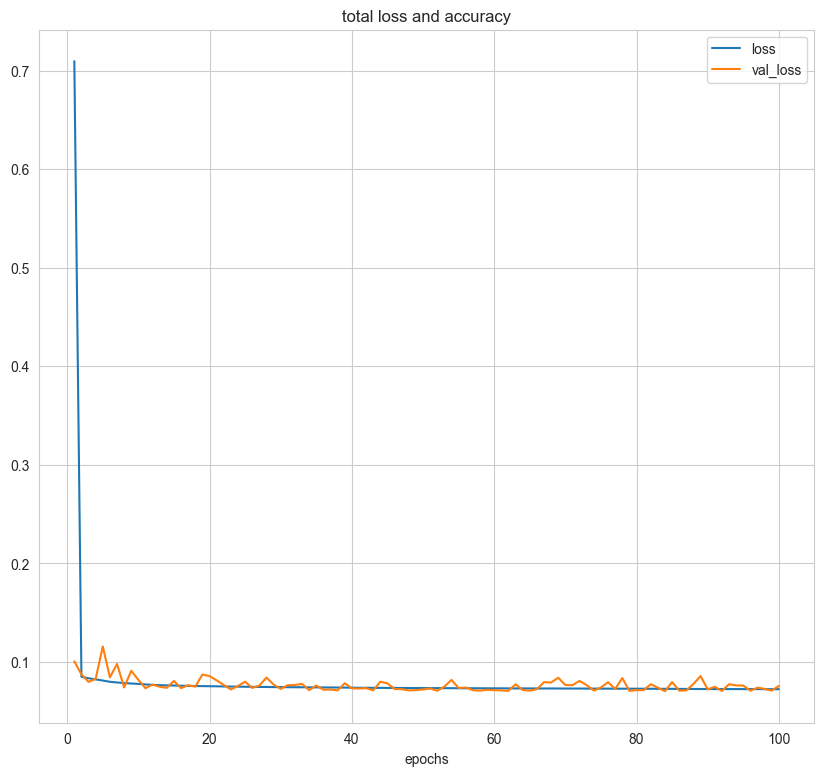

In [27]:
epoch_array = range(1, len(history.history['loss']) + 1)
loss_array = history.history['loss']
val_loss_array = history.history['val_loss']

plt.plot(epoch_array, loss_array, label="loss")
plt.plot(epoch_array, val_loss_array, label="val_loss")
plt.xlabel("epochs")
plt.title("total loss and accuracy")

plt.legend()
plt.show()

In [28]:
y_test_pred = model.predict(x_test)
y_train_pred = model.predict(x_train)
y_data_pred = model.predict(x_data)

rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
rmse_all = mean_squared_error(y_data, y_data_pred, squared=False)

77346/77346 [==============================] - 57s 743us/step


TRAIN Root Mean Squared Error(RMSE): 0.2768754117016024
TEST Root Mean Squared Error(RMSE): 0.27516446843372583
ALL RMSE: 0.27670499651979213


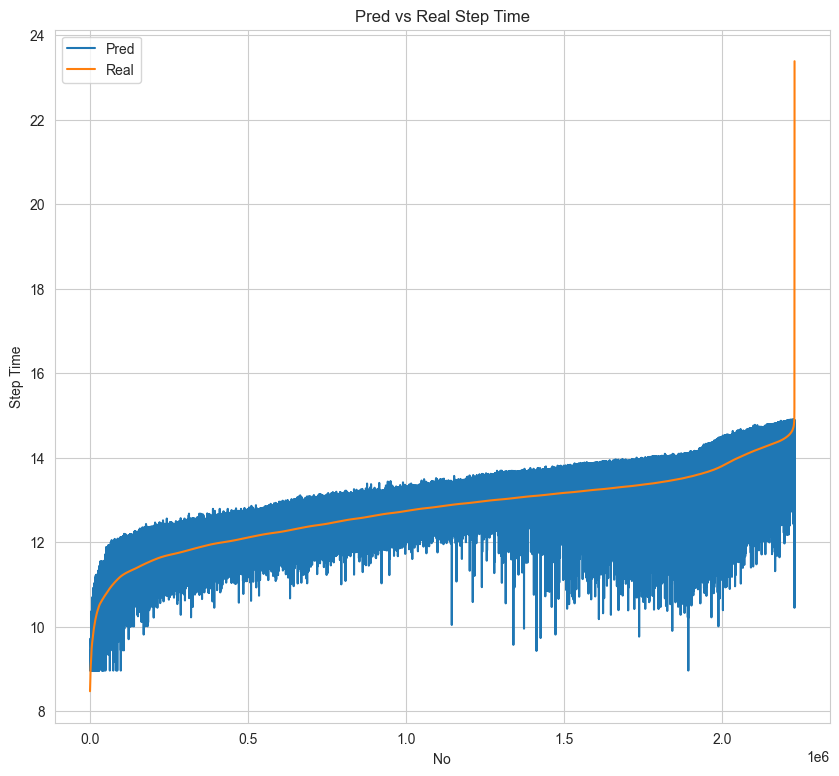

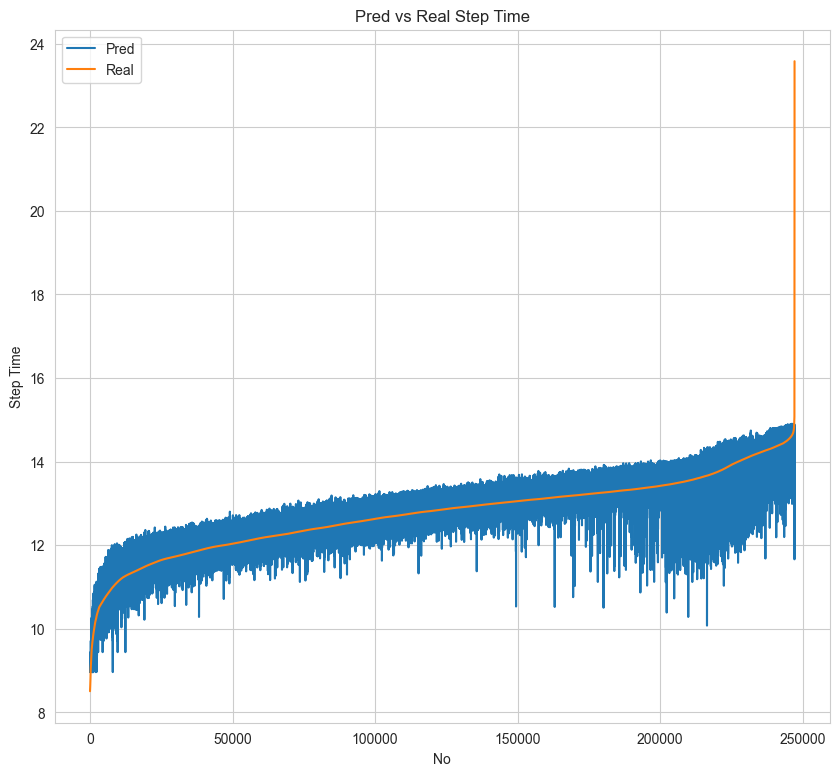

In [30]:
print("TRAIN Root Mean Squared Error(RMSE):", rmse_train)
print("TEST Root Mean Squared Error(RMSE):", rmse_test)
print("ALL RMSE:", rmse_all)
draw_pred_lines(list(y_train_pred[:, -1]), y_train["step_time"].to_list())
draw_pred_lines(list(y_test_pred[:, -1]), y_test["step_time"].to_list())

# Save the Model

In [31]:
model_structure = model.to_json()
with open("./models/ann_30_1_prestep/structure.json", 'w') as json_file:
    json_file.write(model_structure)

model.save_weights("./models/ann_30_1_prestep/weights.h5")